In [2]:
! pip install -q kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sandeshprasadpaudel","key":"74d1fc40a1c6a15f2766cf2b4e79b5f7"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:19<00:00, 168MB/s]
100% 2.29G/2.29G [00:19<00:00, 125MB/s]


In [6]:
! ls

chest-xray-pneumonia.zip  kaggle.json  sample_data


In [7]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
import tensorflow as tf
from tensorflow import keras
import sklearn

In [2]:
train_normal = glob.glob('/content/chest_xray/train/NORMAL/*jpeg')
test_normal = glob.glob('/content/chest_xray/test/NORMAL/*jpeg')
val_normal = glob.glob('/content/chest_xray/val/NORMAL/*jpeg')
train_pneu = glob.glob('/content/chest_xray/train/PNEUMONIA/*jpeg')
test_pneu = glob.glob('/content/chest_xray/test/PNEUMONIA/*jpeg')
val_pneu = glob.glob('/content/chest_xray/val/PNEUMONIA/*jpeg')

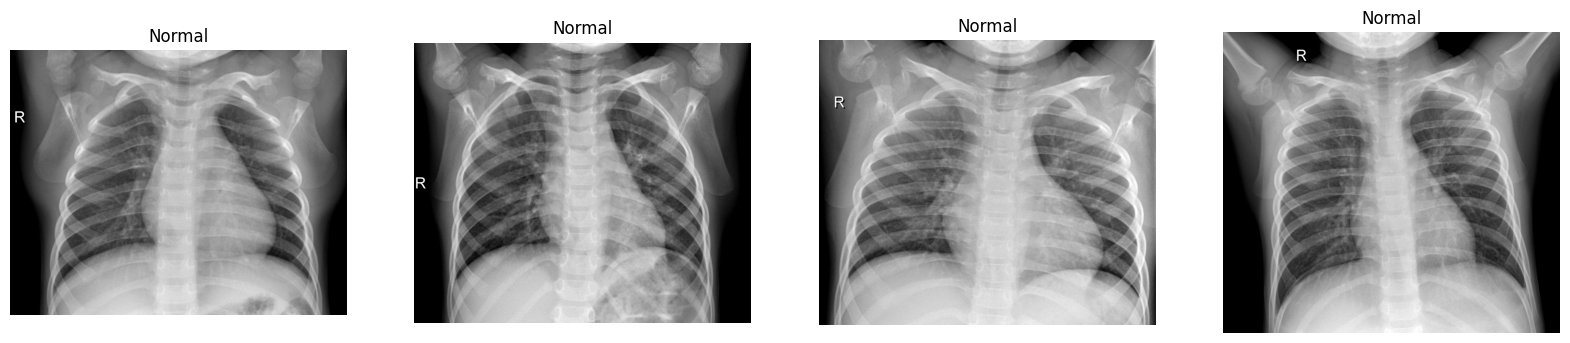

In [3]:
plt.figure(figsize=(20,4))
for i in enumerate(train_normal[0:4]):
    plt.subplot(1,4,i[0]+1)
    plt.axis('off')
    image = plt.imread(i[1])
    plt.imshow(image, cmap='gray')
    plt.title('Normal')

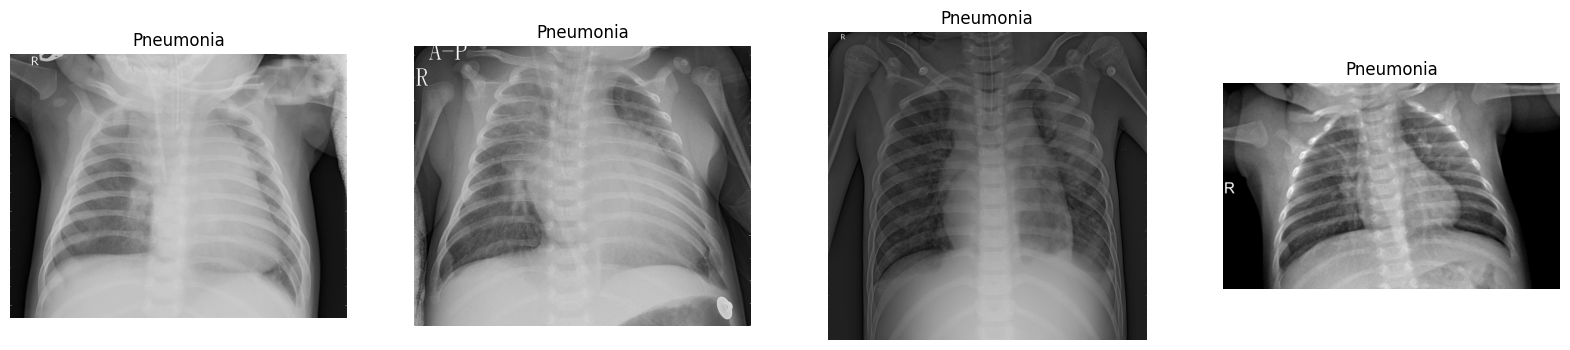

In [4]:
plt.figure(figsize=(20,4))
for i in enumerate(train_pneu[0:4]):
    plt.subplot(1,4,i[0]+1)
    plt.axis('off')
    image = plt.imread(i[1])
    plt.imshow(image, cmap='gray')
    plt.title('Pneumonia')

In [5]:
train_list = []
for x in train_normal:
    train_list.append([x, 0])
for x in train_pneu:
    train_list.append([x, 1])
len(train_list)

5216

In [6]:
import random
random.shuffle(train_list)

In [7]:
train_df = pd.DataFrame(train_list, columns = ['image', 'label'])
def process_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = img/255.0
    img = np.reshape(img, (224, 224, 3))
    return img

def generateXandY(dataframe):
    X = []
    Y = []
    i = 0
    for x,y in dataframe.values:
        X.append(process_image(x))
        Y.append(y)
    return X, Y

In [16]:
X_train, Y_train = generateXandY(train_df)

In [ ]:
X_train = np.asarray(X_train)

In [15]:
X_train.shape

(224, 224, 3)

In [ ]:
# def generateXandY(normal, pneumonia):
#     X = []
#     Y = []
#     for i in normal:
#         img = plt.imread(i)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = cv2.resize(img, (224,224))
#         img = img/255.0
#         X.append(img)
#         Y.append(0)
#     for i in pneumonia:
#         img = plt.imread(i)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = cv2.resize(img, (224,224))
#         img = img/255.0
#         X.append(img)
#         Y.append(1)
#     shuffledX, shuffledY = sklearn.utils.shuffle(np.array(X), np.array(Y))
#     return shuffledX, shuffledY
def generateXandY(labelType, data):
    X = []
    Y = []
    for i in data:
        img = plt.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        img = img/255.0
        X.append(img)
        if labelType=='normal':
            Y.append(0)
        else:
            Y.append(1)
    return np.array(X), np.array(Y)

In [ ]:
train_normal_X, train_normal_Y = generateXandY('normal', train_normal)
# test_X, test_Y = generateXandY(test_normal, test_pneu)
# val_X, val_Y = generateXandY(val_normal, val_pneu)

In [ ]:
train_pneu_X, train_pneu_Y = generateXandY('pneu', train_pneu)

In [ ]:
train_X_unshuffled = np.concatenate((train_normal_X, train_pneu_X), axis=0)
train_Y_unshuffled = np.concatenate((train_normal_Y, train_pneu_Y), axis=0)
train_X, train_Y = sklearn.utils.shuffle(train_X_unshuffled, train_Y_unshuffled)

In [ ]:
train_X.shape

(0,)